# CNN evaluation and predictions

<br>This notebook shows how the CNN models can be used for predicting the centers of the particles with the trained models. 
<br> You can use these examples modules to extract particle centres and check the quality of the predictions via the metrics
<br> The model used here is fully trained.

Finally there is a code for computing the metrics: accuracy and F1 score.

In [1]:
# load the python modules 
from pathlib import Path
import numpy as np 
import torch
import cv2
import glob
import matplotlib.pyplot as plt 

# import the user defined modules
from utils.coord_htmp_exchange import image2coord
from utils.config_utils import load_config
from utils.visualizations import visualise_detection
from utils.metrics import metrics

# import the models
from models import UNetHeatmap

In [2]:
# ........... build the path architecture ........ 
cwd = Path().resolve() 
Parent = cwd.parent
# set file path architecture from the yaml file. 
path_data = load_config(str(cwd.parent / 'configs/config.yaml'))
# path to the image stock (... path the data warehouse ......)
stock_image_dir =cwd.parent / path_data['Images']['Unlabelled_stock']
# path to store the predicted heatmap
heatmaps_pred_w_err_dir = cwd.parent / path_data['Heatmaps']['Errored_HumanOL']
# path to store the images used for prediction 
images_pred_w_err_dir = cwd.parent / path_data['Images']['Errored_HumanOL']
# path to the models
model_path =cwd.parent / path_data['Trained_Models']
# Extract a reference heatmap for ground truth example
heatmap_data_syn = cwd.parent /path_data['Heatmaps']['FirstTrain_syn']

In [3]:
# Set evaluate the model based on the proccessing unit available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = UNetHeatmap()
model = torch.load( str(model_path) + '\CNN_UNET_full_model_512.pth')
model.to(device)
_ = model.eval()

## Detect the particle centers with a image and evaluate the predictions

In [5]:
# define the constants
threshold = 20 #  percentage  
scan_radius = 2 # pixels

In [6]:
stock_image_list = r'C:\Users\tosam\Dropbox\Q\New folder\000002.tif'
img = cv2.imread(stock_image_list, cv2.IMREAD_GRAYSCALE)/255

model.to(device)
model.eval()
    

img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  

# no need for the grad
with torch.no_grad():
    HtMap_pred = model(img.unsqueeze(0).to(device))

# converts to standard grey map and pushes the heatmap to the CPU 
heatmap = HtMap_pred.squeeze().cpu().numpy()*255

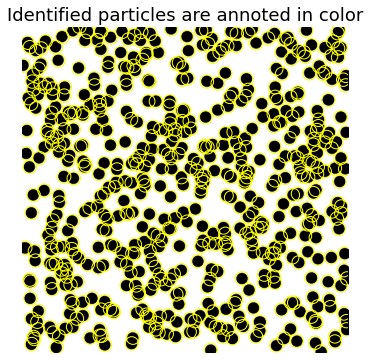

In [7]:
# import the image from the image stock
stock_image_list = glob.glob(str(stock_image_dir)+'\*')[0]
# extract the x and y coordinates
threshold  = 10 
x_coord, y_coord, heatmap = image2coord(model, stock_image_list, device, threshold, scan_radius = 2)

# Now lets annote the image with the detected particles 
visualise_detection(x_coord, y_coord, cv2.imread(stock_image_list, cv2.IMREAD_GRAYSCALE),180, 'yellow')